# Jupyter notebook to test the effectiveness of the CC detection models.

In [101]:
import numpy as np
import pandas as pd
import argparse

import tensorflow as tf
import sklearn as sk
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from datetime import datetime

In [102]:
# Define Default values
csvfile = '../datasets/all_datasets_raw.tsv'
# Less than 5 letters is just too small to know if it is a CC or not. So we set a minimum.
min_letters = 5
# The max 500 letters is arbitrary but we believe that less than 50 letters should be enough to know if it is a CC
max_letters = 500
# In case the sequences are too long to load, is better to never load more than some amount from file to memory. A safeguard
take_last_num = lambda x: x[: max_letters]

In [103]:
# Load the dataframe from the TSV file
df = pd.read_csv(
        csvfile,
        delimiter="|",
        names=["note", "label", "model_id", "state"],
        skipinitialspace=True,
        converters={"state": take_last_num},
    )

In [104]:
# Clean the dataset
df.dropna(axis=0, how="any", inplace=True)
df.drop(axis=1, columns=["note", "model_id"], inplace=True)

In [105]:
# Delete the strings of letters with less than a certain amount
indexNames = df[df["state"].str.len() < min_letters].index
df.drop(indexNames, inplace=True)

In [106]:
# Add a new column to the dataframe with the label. The label is 'Normal' for the normal data and 'Malcious' for the malware data
df.loc[df.label.str.contains("Normal"), "label"] = "Normal"
df.loc[df.label.str.contains("Botnet"), "label"] = "Malicious"
df.loc[df.label.str.contains("Malware"), "label"] = "Malicious"

In [107]:
# Encode the label as an integer. 1 for maliciuos, 0 for benign. 
df.label = df.label.replace("Malicious", 1)
df.label = df.label.replace("Normal", 0)

/tmp/ipykernel_2258671/3015528503.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.label = df.label.replace("Normal", 0)


In [108]:
# Convert each of the stratosphere letters to an integer as an encoding. There are 50 symbols
vocabulary = list("abcdefghiABCDEFGHIrstuvwxyzRSTUVWXYZ1234567890,.+*")
int_of_letters = {}
for i, letter in enumerate(vocabulary):
    int_of_letters[letter] = float(i)
print( f"There are {len(int_of_letters)} letters in total. From letter index {min(int_of_letters.values())} to letter index {max(int_of_letters.values())}.")
vocabulary_size = len(int_of_letters)

There are 50 letters in total. From letter index 0.0 to letter index 49.0.


In [109]:
# Change the letters in the state to an integer representing it uniquely. We 'encode' them.
df["state"] = df["state"].apply(lambda x: [[int_of_letters[i]] for i in x])
# So far, only 1 feature per letter
features_per_sample = 1

In [110]:
# Check how the encoding looks like
df.state.head()

70    [[44.0], [44.0], [45.0], [17.0], [17.0], [49.0...
71    [[36.0], [36.0], [47.0], [27.0], [47.0], [27.0...
73             [[44.0], [41.0], [47.0], [14.0], [47.0]]
75    [[41.0], [41.0], [47.0], [35.0], [47.0], [26.0...
76    [[44.0], [44.0], [47.0], [35.0], [47.0], [26.0...
Name: state, dtype: object

In [111]:
# Convert the data into the appropriate shape
# x_data is a list of lists. The 1st dimension is the outtuple, the second the letter. Each letter is now an int value. shape=(num_outuples, features_per_sample)
x_data = df["state"].to_numpy()
print(f"There are {len(x_data)} outtuples")

There are 2228 outtuples


In [112]:
# y_data is a list of ints that are 0 or 1. One integer per outtupple. shape=(num_outuples, 1)
y_data = df["label"].to_numpy()
print(f"There are {len(y_data)} labels")

There are 2228 labels


In [113]:
# Here x_data is a array of lists [[]]
print(f"x_data type {type(x_data)} of shape {x_data.shape}. x_data[0] type is {type(x_data[0])}")
print(f"x_data[0] is {x_data[0]}")

x_data type <class 'numpy.ndarray'> of shape (2228,). x_data[0] type is <class 'list'>
x_data[0] is [[44.0], [44.0], [45.0], [17.0], [17.0], [49.0], [26.0], [49.0], [45.0], [35.0], [45.0], [17.0]]


In [114]:
# Search the sample with max len in the training. It should be already cuted by the csv_read function to a max. Here we just check
max_length_of_outtupple = max([len(sublist) for sublist in df.state.to_list()])
print(f"The max len of the letters in all outtuples is: {max_length_of_outtupple}")

The max len of the letters in all outtuples is: 500


In [115]:
# Padding.
# Since not all outtuples have the same amount of letters, we need to add padding at the end
# Transforms the list to a 2D Numpy array of shape (num_samples, num_timesteps)
# num_timesteps is either the maxlen argument if provided, or the length of the longest sequence otherwise.
# Sequences that are shorter than num_timesteps are padded with value at the end.
# padding: 'pre' or 'post': pad either before or after each sequence.
# truncating: 'pre' or 'post': remove values from sequences larger than maxlen, either at the beginning or at the end of the sequences.

# If the input are integers
padded_x_data = pad_sequences(
    x_data, maxlen=max_length_of_outtupple, padding="post"
)
print(
        f"padded_x_data is of type {type(padded_x_data)}, of shape {padded_x_data.shape}. padded_x_data[0] type is {type(padded_x_data[0])}. Shape of second list is {padded_x_data[0].shape}"
    )

padded_x_data is of type <class 'numpy.ndarray'>, of shape (2228, 500, 1). padded_x_data[0] type is <class 'numpy.ndarray'>. Shape of second list is (500, 1)


In [116]:
# Split the data in training/evaluation and testing
x_data = padded_x_data
y_data = y_data

X_traineval, X_test, y_traineval, y_test = train_test_split(x_data, y_data, test_size=0.2, random_state=42)

In [117]:
num_outtuples = X_traineval.shape[0]  # number_of_outtuples in general

# In the case of hot-encoding, the amount of features per letter per sample, is 50, which is the vocabulary size
# features_per_sample = vocabulary_size # amount of positions of the hot encoding (50 letters, so 50)
# print(f'We have as input shape: {num_outtuples}, {max_length_of_outtupple}, {features_per_sample}')
# input_shape = (num_outtuples, features_per_sample)

# In the case of not using hot-encoding, the amount of features per sample is 1, because we only have one value
# The amount of time steps is the amount of letters, since one letter is one time step, which is the amount of letters max, which 500
input_shape = (num_outtuples, features_per_sample)
print(
    f"We have as shape: Num of samples: {num_outtuples}, Num of letters per sample (timesteps): {max_length_of_outtupple}, each letter has {features_per_sample} values. The input shape is {input_shape}"
)

We have as shape: Num of samples: 1782, Num of letters per sample (timesteps): 500, each letter has 1 values. The input shape is (1782, 1)


In [118]:
# Model being explored. Used for file name creation.
model_trained = 'v1.1'

# Get current date
model_train_date = datetime.now().strftime('%Y-%m-%d')

In [119]:
# Model v1
# Hyperparameters
vocabulary_size = vocabulary_size
embed_dim = 16

# Create the model of RNN
model = tf.keras.models.Sequential()
model.add(layers.Embedding(vocabulary_size, embed_dim, mask_zero=True))
# GRU is the main RNN layer, inputs: A 3D tensor, with shape [batch, timesteps, feature]
model.add(
    layers.Bidirectional(
        layers.GRU(32, return_sequences=False), merge_mode="concat"
    )
)
model.add(layers.Dense(32, activation="relu"))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation="sigmoid"))
# Fully connected layer with 1 neuron output
# Final output value between 0 and 1 as probability
model.compile(
    loss="binary_crossentropy",
    optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.0001, momentum=0.05),
    metrics=["accuracy"],
)

In [120]:
# Train the model
# This is already separating in trainign and validation

num_epochs = 100
batch_size = 100 # group of outtuples as a batch

history = model.fit(
    X_traineval,
    y_traineval,
    epochs=num_epochs,
    batch_size=batch_size,
    validation_split=0.1,
    verbose=1,
    shuffle=True,
)

Epoch 1/100
17/17 [==============================] - 21s 564ms/step - loss: 0.6898 - accuracy: 0.6151 - val_loss: 0.6846 - val_accuracy: 0.7263
Epoch 2/100
17/17 [==============================] - 6s 341ms/step - loss: 0.6816 - accuracy: 0.7087 - val_loss: 0.6770 - val_accuracy: 0.7263
Epoch 3/100
17/17 [==============================] - 6s 349ms/step - loss: 0.6745 - accuracy: 0.7193 - val_loss: 0.6697 - val_accuracy: 0.7263
Epoch 4/100
17/17 [==============================] - 6s 336ms/step - loss: 0.6693 - accuracy: 0.7130 - val_loss: 0.6618 - val_accuracy: 0.7263
Epoch 5/100
17/17 [==============================] - 6s 346ms/step - loss: 0.6598 - accuracy: 0.7112 - val_loss: 0.6525 - val_accuracy: 0.7263
Epoch 6/100
17/17 [==============================] - 6s 337ms/step - loss: 0.6517 - accuracy: 0.7118 - val_loss: 0.6427 - val_accuracy: 0.7263
Epoch 7/100
17/17 [==============================] - 6s 334ms/step - loss: 0.6423 - accuracy: 0.7112 - val_loss: 0.6335 - val_accuracy: 0.726

In [85]:
model_outputfile = f'../rnn_model_{model_trained}_2024-04-20.h5'
model.summary()
model.save(model_outputfile, overwrite=False)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 16)          800       
                                                                 
 bidirectional_1 (Bidirecti  (None, 64)                9600      
 onal)                                                           
                                                                 
 dense_2 (Dense)             (None, 32)                2080      
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense_3 (Dense)             (None, 1)                 33        
                                                                 
Total params: 12513 (48.88 KB)
Trainable params: 12513 (48.88 KB)
Non-trainable params: 0 (0.00 Byte)
__________________

/home/sebas/miniconda3/envs/slips/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


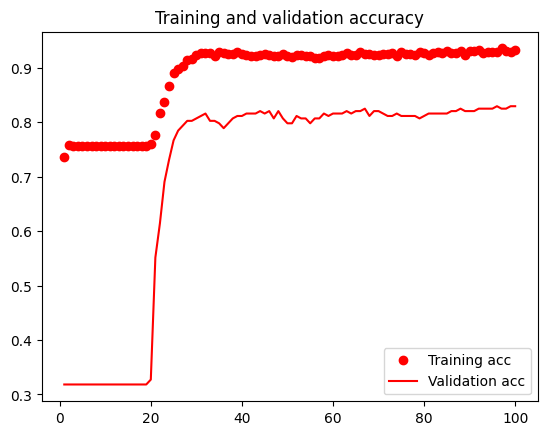

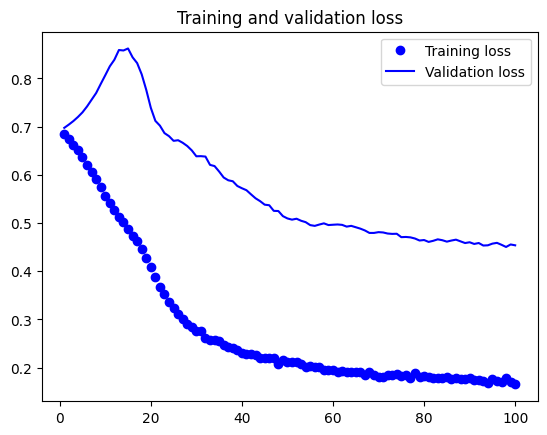

In [100]:
# To plot the results of training
import matplotlib.pyplot as plt

acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, "ro", label="Training acc")
plt.plot(epochs, val_acc, "r", label="Validation acc")

plt.title("Training and validation accuracy")
plt.legend()
plt.savefig(f"rnn_model_{model_trained}-{model_train_date}.acc.png")
plt.show()

plt.close()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.savefig(f"rnn_model_{model_trained}-{model_train_date}.loss.png")
plt.show()

In [99]:
# Evaluate model on the new dataset
loss, accuracy = model.evaluate(X_test, y_test)

# Print evaluation results
print("Test Generatilization Results:")
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

14/14 [==============================] - 1s 62ms/step - loss: 0.1779 - accuracy: 0.9260
Test Generatilization Results:
Test Loss: 0.17785538733005524
Test Accuracy: 0.926008939743042
